J'utilise l'algorithme EM pour estimer les poids des gaussiennes à partir des observations de températures. Il y a 4 classes mais la 1re classe n'est pas représentée dans les donné (aucune occurence dans la série des labels). J'ai ainsi étudié les résultats de l'algorithme EM selon qu'on lui indique 3 ou 4 classes. Les résultats sont meilleurs si on utilise seulement 3 classes. 

In [5]:
import csv
import numpy as np
from math import *

obs = [] #array to store observed temperatures
labels = [] #array to store true class labels
posteriors = [] #array to store posteriors from all classes
activations = [] #array to store activations from all classes
R = 0 #Observation noise variance

#Retrive temperatures and true class labels from csv file
with open('pour_martin_ix70_iy115_iz26.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    l = 0
    for row in spamreader:
        if l == 0:
            l = 1 #first row is titles, we skip it
        else:
            arr = row[0].split('\t')
            obs.append(float(arr[1]))
            labels.append(int(arr[2]))
            tmpP= []
            tmpA = []
            for k in range(4):
                tmpP.append(float(arr[3+k]))
                tmpA.append(float(arr[7+k]))
            posteriors.append(tmpP)
            activations.append(tmpA)

n = len(obs) #number of observations
#obs = np.array(obs)
labels = np.array(labels)
posteriors = np.array(posteriors)
#activations = np.array(activations)

#Class means and variances
gaus_mean = np.array([4.70226841574216, 7.70938140771444, 15.4116575244064, 18.5364702094555])
gaus_var = np.array([0.164338465357345, 1.27622462394194, 2.02625911575517, 0.232444749797503])**2

Toutes les fonctions avec le mot 'map' servent à permuter les données d'origine afin que les classes trouvés par l'algorithme EM
correspondent avec celles d'origine (par exemple afin que la classe 1 des données corresponde bien à la classe 1 de l'algo EM)

In [6]:
#Compute error rate
def error_rate(trues, ests):
    error = 0
    for t in range(n):
        if ests[t] != trues[t]:
            error += 1
    return error/len(trues)
#Not used
def learn_map(e_means):
    mapping = np.array(sorted(range(len(e_means)), key=lambda k: e_means[k]))
    return mapping

def learn_map4(e_means):
    mapping = np.zeros((4,))
    for k in range(4):
        if int(e_means[k]) == 18:
            mapping[k] = 3
        elif int(e_means[k]) == 15:
            mapping[k] = 2
        elif int(e_means[k]) == 11:
            mapping[k] = 1
        elif int(e_means[k]) == 8:
            mapping[k] = 0
    return mapping

def learn_map3(e_means):
    mapping = np.zeros((3,))
    for k in range(3):
        if int(e_means[k]) == 18:
            mapping[k] = 2
        elif int(e_means[k]) == 14:
            mapping[k] = 1
        elif int(e_means[k]) == 8 or int(e_means[k])== 9:
            mapping[k] = 0
    return mapping
            
def map_labels(l,mapping):
    new = np.array(l)
    for n in range(len(l)):
        temp = int(l[n])
        new[n] = np.nonzero(mapping == temp)[0][0]
        #new[n] = mapping[temp]
    return new

def map_vec(l,mapping):
    new = np.array(l)
    for n in range(len(mapping)):
        new[n] = l[int(mapping[n])]
    return new

def map_mat(mat, mapping):
    M,N = mat.shape
    new = np.zeros((M,N))
    for m in range(M):
        for n in range(N):
            new[m,n] = mat[m, int(mapping[n])]
    return new
    

In [7]:
from sklearn.mixture import GaussianMixture
KS = [4,3]
all_est_pis = []
all_sorted_pis = []
all_est_temp = []
all_est_temp2 = []
all_est_temp3 = []


for K in KS:
    print('Number of classes used by EM')
    print(K)
    gm = GaussianMixture(K)
    obs = np.reshape(obs,(n,1))
    gm.fit(obs)
    est_pis = np.array(gm.predict_proba(obs))
    all_est_pis.append(est_pis)

    if K == 3:
        mapping = learn_map(gm.means_)
    elif K == 4:
        mapping = learn_map(gm.means_)
    print('Mapping')    
    print(mapping)
    est_labels = np.zeros((n,))
    for t in range(n):
        est_labels[t] = np.argmax(est_pis[t])

    
    #sorted_labels = map_labels(labels -(5-K), mapping)
    sorted_labels = map_labels(est_labels, mapping)
    #sorted_means = map_vec(gaus_mean[4-K:4], mapping)
    sorted_means = map_vec(gm.means_, mapping)
    #sorted_posts = map_mat(posteriors[:,4-K:4], mapping)
    sorted_pis = map_mat(est_pis, mapping)
    
    all_sorted_pis.append(sorted_pis)
    
    err = error_rate(labels-(5-K),sorted_labels)
    print('Means found by EM algorithm')
    print(gm.means_)
    print('Given means')
    print(gaus_mean)
    print('EM means sorted according to mapping so that their positions match with given means ones')
    print(sorted_means)
    print('####################')


    est_temp = est_pis.dot(gm.means_)
    all_est_temp.append(est_temp)
    est_temp2 = sorted_pis.dot(np.transpose(gaus_mean[4-K:]))
    all_est_temp2.append(est_temp2)
    est_temp3 = posteriors[:,4-K:].dot(np.transpose(gaus_mean[4-K:]))
    all_est_temp3.append(est_temp3)

Number of classes used by EM
4
Mapping
[3 1 2 0]
Means found by EM algorithm
[[ 18.23570005]
 [ 11.16030374]
 [ 15.08072383]
 [  8.25552783]]
Given means
[  4.70226842   7.70938141  15.41165752  18.53647021]
EM means sorted according to mapping so that their positions match with given means ones
[[  8.25552783]
 [ 11.16030374]
 [ 15.08072383]
 [ 18.23570005]]
####################
Number of classes used by EM
3
Mapping
[1 2 0]
Means found by EM algorithm
[[ 18.23767568]
 [  9.16432928]
 [ 14.36034932]]
Given means
[  4.70226842   7.70938141  15.41165752  18.53647021]
EM means sorted according to mapping so that their positions match with given means ones
[[  9.16432928]
 [ 14.36034932]
 [ 18.23767568]]
####################


Pour estimer la température, j'ai utilisé alternativement: 
- La somme des moyennes calculées par l'EM pondérés par les poids calculées par l'EM (courbe bleue)
- La somme des moyennes que tu m'as données Guillaume pondérés par les poids calculés par l'EM (courbe verte)
- La somme des moyennes que tu m'as données Guillaume pondérés par les poids donnés (série des posteriors) (courbe cyan)

La courbe cyan est très carrée car les poids dans la série des postériors sont souvent proches de 0 ou 1. Les moyennes calculées par l'EM sont moins précises que celles données (ce qui est normal). En effet, la courbe bleue colle moins au valeurs observées (courbe rouge) que la courbe verte.

Populating the interactive namespace from numpy and matplotlib


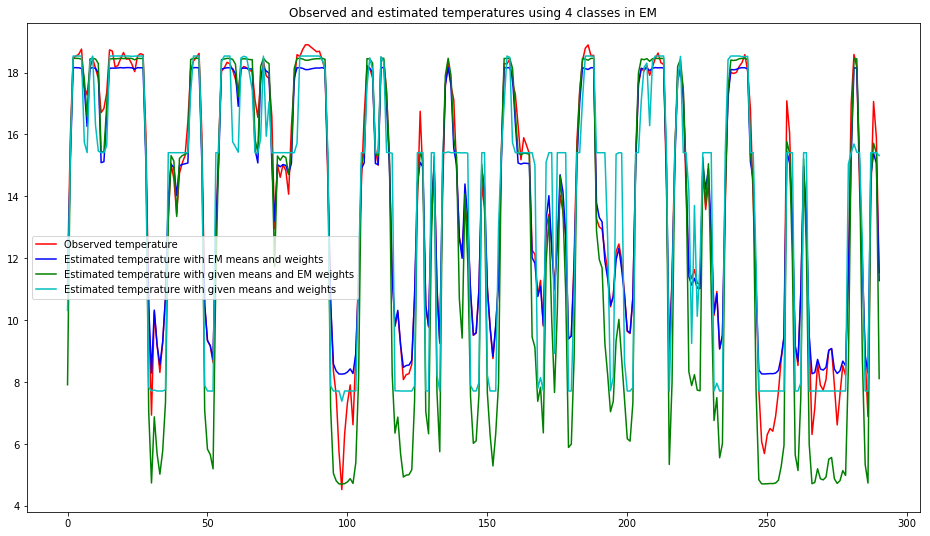

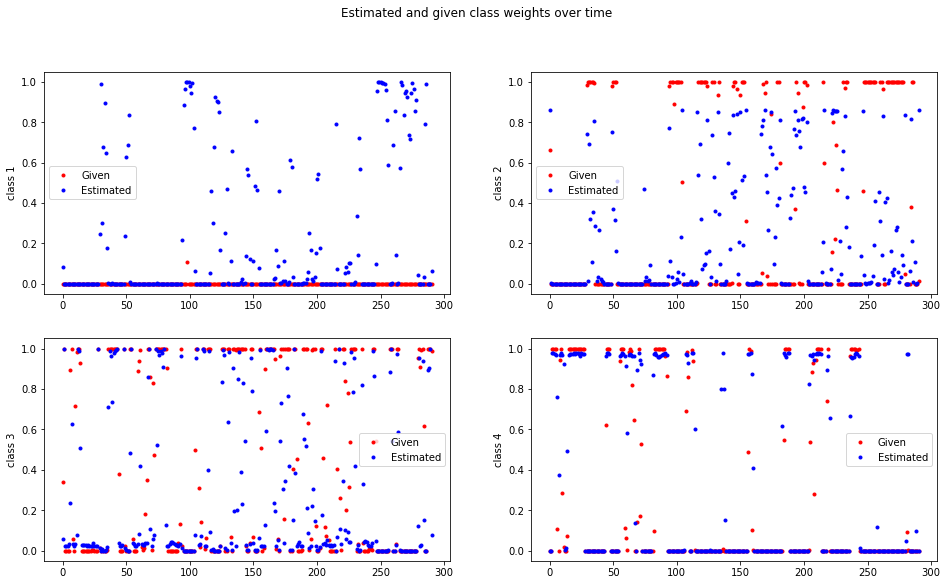

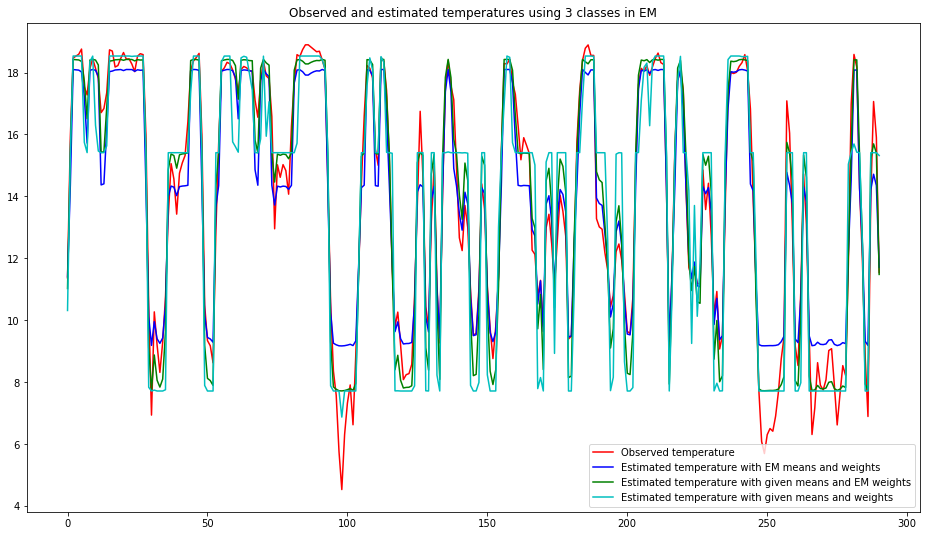

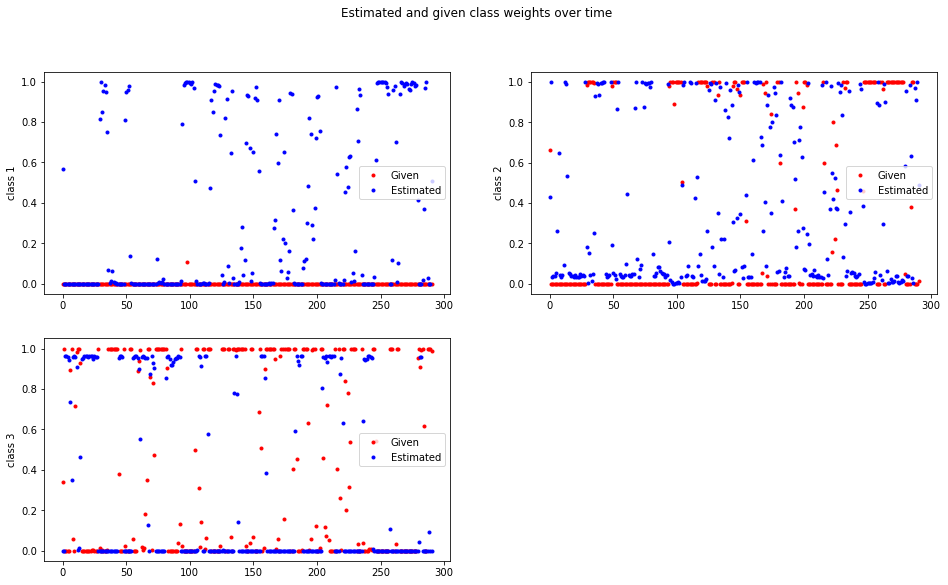

In [8]:
%pylab inline
pylab.rcParams['figure.figsize'] = (16.0, 9.0)

import warnings
warnings.filterwarnings('ignore')
for i in range(len(KS)):
    K = KS[i]
    figure(1+2*i)
    plot(range(n), obs,'r', label='Observed temperature')
    plot(range(n), all_est_temp[i],'b', label='Estimated temperature with EM means and weights')
    plot(range(n), all_est_temp2[i],'g', label='Estimated temperature with given means and EM weights')
    plot(range(n), all_est_temp3[i],'c', label='Estimated temperature with given means and weights')
    legend()
    title('Observed and estimated temperatures using {0} classes in EM'.format(K))

    figure(2+2*i)
    y_label=('class 1','class 2','class 3','class 4')
    suptitle('Estimated and given class weights over time')
    for k in range(K):
        subplot(2,2,k+1)
        plot(range(n), posteriors[:,k],'.r', label='Given')
        plot(range(n), all_sorted_pis[i][:,k],'.b', label='Estimated')
        ylabel(y_label[k])
        legend()
